# Modelado de sistema de recomendación basado en el contenido (item-item)

##

In [0]:
## ------- Importando librerias
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from datetime import datetime

In [0]:
#df_2014 = spark.sql("SELECT * FROM reviews WHERE YEAR(date) = 2014")
df_2014 = spark.sql("SELECT * FROM reviews_2014_ml WHERE categories LIKE 'Books' LIMIT 300000") #Query para elegir los productos de cierta categoría/ libros
df_1 = df_2014.toPandas()
#df_1 = df_1.head(300000)
icols = ['reviewerID', 'asinID', 'overall']
revrating = df_1.loc[:,icols]
revrating.head()

Out[9]:

,reviewerID,asinID,overall
0,A28MZTMHZ2RR4B,0002242052,5.0
1,A3886QZPJYV6Z5,0002242052,5.0
2,A212P00TI2GUJ2,0002242052,4.0
3,A2F26J4YD4PDGL,0002242052,5.0
4,A1MKQR4NFQ5M08,0002242052,4.0


In [0]:
#Revisando el numero de filas y columnas
rows, columns = revrating.shape
print('No. of rows:', rows)
print('No. of columns:', columns)

No. of rows: 300000
No. of columns: 3

In [0]:
#Check column types
revrating.dtypes

Out[392]: reviewerID object
asinID object
overall float64
dtype: object

In [0]:
revrating['overall'].describe()

Out[393]: count 300000.000000
mean 4.327437
std 0.998608
min 1.000000
25% 4.000000
50% 5.000000
75% 5.000000
max 5.000000
Name: overall, dtype: float64

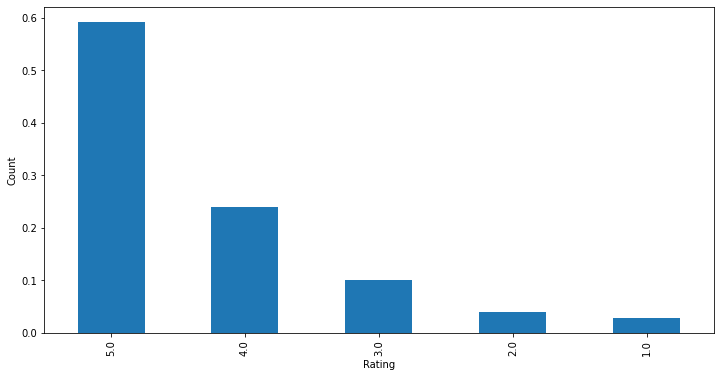

In [0]:
#Creando la grafica para analizar

plt.figure(figsize = (12,6))
revrating['overall'].value_counts(1).plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [0]:
#Las reviewss más comunes son de 5 estrellas
#cerca del 80% son reviews positivas con 5 o 4 estrellas
#menos del 20% son reviews de menos de 3 estrellas

In [0]:
#numero de usuarios unicos en el dataset
print('Numero de usuarios unicos en la data:', revrating['reviewerID'].nunique())
print('Numero de items unicos en la data:', revrating['asinID'].nunique())

Numero de usuarios unicos en la data: 161443
Numero de items unicos en la data: 36011

In [0]:
#Top 10 de usuarios que hacen reviews
most_rated = revrating.groupby('asinID').size().sort_values(ascending=False)[:10]
most_rated

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-645198131775296> in <module> 
 1 #Top 10 de usuarios que hacen reviews 
 ----> 2 most_rated = revrating . groupby ( 'asinID' ) . size ( ) . sort_values ( ascending = False ) [ : 10 ] 
 3 most_rated

 NameError : name 'revrating' is not defined

In [0]:
#El usario con más reviews posee 3601. Prepararemos un sistema de recomendacion de productos en donde el usuario no haya interactuado con ellos.

In [0]:
counts = revrating['reviewerID'].value_counts()
df_final = revrating[revrating['reviewerID'].isin(counts[counts >= 20].index)]

In [0]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['reviewerID'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['asinID'].nunique())

The number of observations in the final data = 9901
Number of unique USERS in the final data = 343
Number of unique PRODUCTS in the final data = 4482

In [0]:
#El dataframe dinal df_final posee los usuarios que han realizado review de 50 o más productos
#Usaremos df_final para construir los sistemas de recomendación

In [0]:
#Eliminamos valores duplicados
df_final = df_final.drop_duplicates()

In [0]:
#Creando la matriz de interaccion de productos y usuarios basados en ratings
final_ratings_matrix = df_final.pivot(index = 'reviewerID', columns ='asinID', values = 'overall').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Encontrando el numero de entradas (no cero) en la matriz de interacción
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Buscando el numero posible de ratings por numero de usuarios y productos
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Densidad de ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix: (343, 4482)
given_num_of_ratings = 9901
possible_num_of_ratings = 1537326
density: 0.64%
Out[15]:

asinID,000224053X,0006145388,000616823X,0006176909,0006479901,0007163541,0007444117,0007491433,000755947X,0026009102,0030615534,0060008725,0060009241,0060009268,0060084081,0060086246,0060091290,006009334X,0060098902,0060150866,0060185430,0060193506,0060256656,0060268379,0060273224,0060505753,0060507365,0060509058,0060518499,0060520515,0060531258,0060540753,0060541431,0060541903,0060545801,0060562498,0060577487,0060578122,0060579080,0060584750,...,1939962404,1939962439,1939976022,1939985013,1940095174,1940099110,1940202930,194021517X,1940215218,194026202X,1940262054,1940305020,1940427029,1940517001,1940534410,1940544009,1940584000,1940601010,1940652073,1940727065,1940734142,1940820022,1940820103,1940832977,1940846005,1940883172,1940887038,1940887054,1940941423,194095102X,1941098037,1941098126,1941145140,194141902X,1941450008,1941699006,3906196003,9881616409,9899734810,B0022WDIZS
reviewerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A102Z3T7NSM5KC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103M7E0BSFC83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1098Z3D7ENJ2F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10DX94ATZQEFG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10W5M10DGKVYQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Sistema de recomendacion basada en el rank

In [0]:
#Calula el rating promedio para cada producto
average_rating = df_final.groupby('asinID').mean()['overall']

#Calcula el numero de ratings para cada producto
count_rating = df_final.groupby('asinID').count()['overall']

#Creación del dataframe con el promedio y el conteo de ratings para cada producto
final_rating = pd.DataFrame({'Avg Rating': average_rating, 'Rating count': count_rating})

#Ordenando el dataframe por el promedio de ratings
final_rating = final_rating
final_rating.sort_values(by='Rating count', ascending=False, inplace=True)

final_rating.head()

Out[17]:

,Avg Rating,Rating count
asinID,,
149539090X,4.914286,35
0062333038,4.482759,29
0778315991,4.185185,27
0062235591,3.730769,26
1496145437,4.846154,26


In [0]:
#Definiendo una función para obetener el top n de productos basados en el promedio más alto de ratings y el minimo de interacciones
def top_n_products(final_rating, n, min_interaction):
    
    #Finding movies with minimum number of interactions
    recommendations = final_rating[final_rating['Rating count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations.sort_values(by='Avg Rating', ascending=False, inplace=True)
    
    return recommendations.index[:n]

In [0]:
#Recomendacion del top 5 de prodcutos con 10 interacciones minimas basadas en popularidad
list(top_n_products(final_rating, 5, 10))



Out[19]: ['149539090X', '0988742942', '1496145437', '1401688543', '1616260408']

In [0]:
#Recomendacion del top 5 de prodcutos con 25 interacciones minimas basadas en popularidad
list(top_n_products(final_rating, 5, 25))

Out[20]: ['149539090X', '1496145437', '0062333038', '0778315991', '0062235591']

## Sistema de recomendación basado en el filtrado colaborativo

In [0]:
final_ratings_matrix.head()

Out[21]:

asinID,000224053X,0006145388,000616823X,0006176909,0006479901,0007163541,0007444117,0007491433,000755947X,0026009102,0030615534,0060008725,0060009241,0060009268,0060084081,0060086246,0060091290,006009334X,0060098902,0060150866,0060185430,0060193506,0060256656,0060268379,0060273224,0060505753,0060507365,0060509058,0060518499,0060520515,0060531258,0060540753,0060541431,0060541903,0060545801,0060562498,0060577487,0060578122,0060579080,0060584750,...,1939962404,1939962439,1939976022,1939985013,1940095174,1940099110,1940202930,194021517X,1940215218,194026202X,1940262054,1940305020,1940427029,1940517001,1940534410,1940544009,1940584000,1940601010,1940652073,1940727065,1940734142,1940820022,1940820103,1940832977,1940846005,1940883172,1940887038,1940887054,1940941423,194095102X,1941098037,1941098126,1941145140,194141902X,1941450008,1941699006,3906196003,9881616409,9899734810,B0022WDIZS
reviewerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A102Z3T7NSM5KC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103M7E0BSFC83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1098Z3D7ENJ2F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10DX94ATZQEFG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10W5M10DGKVYQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#Aqui el reviewerID (index) es el tipo de dato. Reemplazamos el reviewerID por los numeros empezando desde 0 (para todos los id de reviewer) tal que el indice es numero entero y representa el id del usuario en el mismo formato.

In [0]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Ratings actual dados por los usuarios
final_ratings_matrix.head()

Out[22]:

asinID,000224053X,0006145388,000616823X,0006176909,0006479901,0007163541,0007444117,0007491433,000755947X,0026009102,0030615534,0060008725,0060009241,0060009268,0060084081,0060086246,0060091290,006009334X,0060098902,0060150866,0060185430,0060193506,0060256656,0060268379,0060273224,0060505753,0060507365,0060509058,0060518499,0060520515,0060531258,0060540753,0060541431,0060541903,0060545801,0060562498,0060577487,0060578122,0060579080,0060584750,...,1939962404,1939962439,1939976022,1939985013,1940095174,1940099110,1940202930,194021517X,1940215218,194026202X,1940262054,1940305020,1940427029,1940517001,1940534410,1940544009,1940584000,1940601010,1940652073,1940727065,1940734142,1940820022,1940820103,1940832977,1940846005,1940883172,1940887038,1940887054,1940941423,194095102X,1941098037,1941098126,1941145140,194141902X,1941450008,1941699006,3906196003,9881616409,9899734810,B0022WDIZS
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#Ahora definimos la funcion para obtener usuarios similares a partir de un usuario unico

In [0]:
# Definimos una funcion para obtener usuarios similares
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]):
        
        #Calculamos la similaridad del coseno entre el reviewerID y cada usuario
        sim = cosine_similarity([final_ratings_matrix.loc[user_index]], [final_ratings_matrix.iloc[user]])
        
        #Agregando el usuario y el puntaje de similaridad correspondiente con el reviewerID como tupla
        similarity.append((user, sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extraemos el usuario de la tupla en la lista
    similarity_score = [tup[1] for tup in similarity] ##Extraemos el puntaje de similaridad de cada tupla en la lista
       
    #Removemos el usuario original y su puntaje de similaridad y nos quedamos con los usuarios simialres
    most_similar_users.remove(user)
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

In [0]:
#Encontrando el top 10 de usuarios similares para el usuario con indice 3 y su respectivo puntaje de similaridad

similar = similar_users(3, final_ratings_matrix)[0][0:10]
similar

Out[24]: [3, 206, 50, 237, 111, 183, 39, 126, 80, 67]

In [0]:
#Imprimimos el puntaje de similaridad
similar_users(3, final_ratings_matrix)[1][0:10]

Out[25]: [array([[0.33003592]]),
 array([[0.20321176]]),
 array([[0.1958637]]),
 array([[0.18778036]]),
 array([[0.1523858]]),
 array([[0.14955752]]),
 array([[0.14019424]]),
 array([[0.13688834]]),
 array([[0.12868134]]),
 array([[0.12847692]])]

In [0]:
#Encontrando el top 10 de usuarios similares al usuario con indice 200 y su puntaje de similaridad
similar = similar_users(200, final_ratings_matrix)[0][0:10]
similar

Out[26]: [200, 173, 154, 167, 298, 293, 17, 324, 248, 265]

In [0]:
#Imprimimos el puntaje de similaridad
similar_users(200, final_ratings_matrix)[1][0:10]

Out[27]: [array([[0.39179141]]),
 array([[0.36522426]]),
 array([[0.30549023]]),
 array([[0.29507038]]),
 array([[0.28887023]]),
 array([[0.28500417]]),
 array([[0.27833222]]),
 array([[0.26634877]]),
 array([[0.26568632]]),
 array([[0.25543312]])]

In [0]:
#Encontramos usuarios similares dado un usuario especifíco. Ahora, creamos una funcion para recomendar productos al usuario, utilizando los ratings dados por los usuarios similares.

In [0]:
#Definimos una funcion de recomendacion para obtener recomendaciones utilizando las preferencias similares de los ususuarios
def recommendations(user_index, num_of_products, interactions_matrix):
        
    #Guardamos los usuarios similares utilizando la funcion 'similar_users' definida arriba
    most_similar_users = similar_users(user_index, interactions_matrix)[0]
    
    #Encontramos los ID de los productos con los que el 'user_id' ha interactuado    
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            
            #Encontramos 'n' productos loc aules han sido puntuados por usuarios similares pero no por el 'user_id'            
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break
    
    return recommendations[:num_of_products]

In [0]:
#Recomendamos 5 productos al usuario con indice 3 con el filtrado colaborativo basado en similaridad
recommendations(3, 5, final_ratings_matrix)

Out[29]: ['045141568X', '162322117X', '0988994798', '037343040X', '0758288956']

In [0]:
#Recomendamos 5 productos al usuario con indice 200 con el filtrado colaborativo basado en similaridad
recommendations(200, 5, final_ratings_matrix)

Out[30]: ['1616260408', '0800720725', '0764210335', '0310335159', '0307731278']

In [0]:
#Con esto, hemos aplicado dos tecnicas para recomendar productos a los usuarios. Ahora, vamos a construir un sistema de recomendación utilizando una matriz de factorización (SVD)

### Modelo basado en el filtrado colaborativo: 'Singular Value Decomposition'

In [0]:
# Hemos visto la dispersion de la matriz de interacción. SVD es el mejor modelo para aplicar a la matriz. Notese que para las matrices dispersas, podemos utilizar la funcion 'sparse.linalg.svds()' para realizar la descomposición
#También, usamos k=50 que son las caracteristicas latentes para predecir el rating de los productos.

In [0]:
from scipy.sparse.linalg import svds # Para las matrices dispersas

# Singular Value Decomposition (SVD)
U, s, Vt = svds(final_ratings_matrix, k = 50) # Aqui 'k' es el numero de caracteristicas latentes

# Construimos un arreglo diagonal en SVD
sigma = np.diag(s)

In [0]:
U.shape #Revisando el shape de la matriz U

Out[32]: (343, 50)

In [0]:
sigma.shape #Revisando el shape de la matriz sigma

Out[33]: (50, 50)

In [0]:
Vt.shape #Revisando el shape de la matriz Vt

Out[34]: (50, 4482)

In [0]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma),Vt) 

# Ratings predichos
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()

Out[35]:

asinID,000224053X,0006145388,000616823X,0006176909,0006479901,0007163541,0007444117,0007491433,000755947X,0026009102,0030615534,0060008725,0060009241,0060009268,0060084081,0060086246,0060091290,006009334X,0060098902,0060150866,0060185430,0060193506,0060256656,0060268379,0060273224,0060505753,0060507365,0060509058,0060518499,0060520515,0060531258,0060540753,0060541431,0060541903,0060545801,0060562498,0060577487,0060578122,0060579080,0060584750,...,1939962404,1939962439,1939976022,1939985013,1940095174,1940099110,1940202930,194021517X,1940215218,194026202X,1940262054,1940305020,1940427029,1940517001,1940534410,1940544009,1940584000,1940601010,1940652073,1940727065,1940734142,1940820022,1940820103,1940832977,1940846005,1940883172,1940887038,1940887054,1940941423,194095102X,1941098037,1941098126,1941145140,194141902X,1941450008,1941699006,3906196003,9881616409,9899734810,B0022WDIZS
0,0.001065,0.003417,0.006820,0.012654,0.005291,0.031357,0.117653,0.002041,0.064247,0.001228,0.016964,0.001182,0.007359,0.005526,0.001478,0.007545,0.015919,0.014520,0.085892,0.016964,0.002403,0.002646,3.853055e-18,0.016964,0.006398,0.010166,0.000322,0.004652,0.005129,0.010059,0.004324,0.005373,0.055624,0.007640,0.002118,0.018920,0.005519,0.002118,0.051183,0.001735,...,0.005795,0.014434,0.001728,0.006375,0.010592,0.013004,0.004113,0.009105,0.008310,0.008374,0.001359,0.015420,0.002898,0.003051,0.016186,0.014967,0.018524,0.038350,0.031235,0.000784,0.000333,0.002583,0.002009,0.022712,0.000008,0.094084,0.011106,0.000227,0.016833,0.127762,0.044641,0.060035,0.016938,0.003004,0.009155,0.001944,0.067961,0.020259,0.023371,0.017344
1,0.001195,0.003413,0.003948,0.026596,0.002845,0.004638,0.129094,0.014446,0.030507,0.001420,0.047983,0.005818,0.011353,0.002760,0.007273,0.027236,0.013516,0.006216,0.028582,0.047983,0.025904,0.001422,4.985794e-18,0.047983,0.004108,0.015226,0.000345,0.003575,0.001238,0.036315,0.006367,0.004163,0.001369,0.012234,0.013460,0.009912,0.008514,0.013460,0.026429,0.011968,...,0.028074,0.001852,0.011861,0.010256,0.006949,0.021539,0.064028,0.007131,0.074562,0.034254,0.009341,0.172760,0.190253,0.011833,0.036489,0.013384,0.013379,0.517773,0.164651,0.024827,0.023957,0.003241,0.010074,0.009885,0.134672,0.428801,0.081388,0.020849,0.841119,1.202031,0.097788,0.133002,0.002597,0.032380,0.443346,0.014517,0.009849,0.039855,0.153785,0.005329
2,0.000452,0.006451,0.000681,0.036890,0.000266,0.043038,0.437735,0.003074,0.049005,0.005506,0.037884,0.008129,0.024806,0.042027,0.010161,0.029549,0.052369,0.037750,0.063046,0.037884,0.007962,0.000133,8.024270e-17,0.037884,0.004028,0.034217,0.001070,0.006107,0.003673,0.039398,0.014543,0.002685,0.083796,0.003474,0.031924,0.062121,0.018605,0.031924,0.181025,0.007953,...,0.038128,0.599611,0.005540,0.007342,0.032577,0.030568,0.068268,0.035034,0.079677,0.011130,0.028113,0.542286,0.022443,0.086072,0.070665,0.024686,0.192575,0.379168,0.526127,0.014656,0.003422,0.012610,0.006114,0.732192,0.052270,0.144720,0.390947,0.010755,0.355462,0.769711,1.172405,0.846735,0.025142,0.009952,0.137796,0.016774,0.003108,0.006133,0.248909,0.004030
3,0.000601,0.013701,0.006225,0.001023,0.006100,0.001742,0.367386,0.002268,0.129838,0.000752,0.006628,0.000819,0.062472,0.098219,0.001024,0.041377,0.119165,0.004909,0.146921,0.006628,0.004459,0.003050,6.597049e-17,0.006628,0.000628,0.082921,0.001610,0.019961,0.015594,0.055170,0.034457,0.003426,0.006614,0.006290,0.085458,0.142785,0.046854,0.085458,0.300010,0.004510,...,0.119743,0.082530,0.050634,0.028447,0.008960,0.153283,0.014556,0.065224,0.032432,0.040912,0.055109,0.894662,0.079070,0.457866,0.056122,0.027115,0.219538,0.018774,0.106944,0.009483,0.009181,0.093831,0.000799,0.571978,0.244290,0.844488,0.301839,0.368060,0.250080,0.192557,0.362516,0.689633,0.163345,0.005574,0.031976,0.017520,0.111389,0.007410,0.122944,0.032923
4,0.000360,0.005807,0.004775,0.010440,0.001931,0.046451,0.023264,0.011347,0.109369,0.001693,0.034242,0.003315,0.000777,0.030741,0.004144,0.033090,0.017601,0.016439,0.137806,0.034242,0.01938

In [0]:
#We have the prediction of ratings but we need to create a function to recommend products to the users on the basis of predicted ratings for each product

In [0]:
# Recomendando los productos con los altos ratings predecidos.

def recommend_items(user_index, interactions_matrix, preds_df, num_recommendations):
    
    # Obtenemos y ordenamos los ratings de los usuarios de la matriz de interacción actual y predecida.
    sorted_user_ratings = interactions_matrix.loc[user_index].sort_values(ascending=False)
    sorted_user_predictions = preds_df.loc[user_index].sort_values(ascending=False)

    #Creamos un dataframe con los ratings actuales y predecidos.    
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Productos recomendados'
    temp.columns = ['user_ratings', 'user_predictions']
    
    #Filtramos el dataframe donde los ratings acutales son 0, lo cual implica que el usuario no ha interactuado con ese producto
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recomendamos los productos por los top ratings predecidos.    
    temp = temp.sort_values('user_predictions', ascending=False) #Ordenamos el dataframe por 'user_predictions' por orden descendente
    #print('\nDebajo se muestran las recomendaciones para el usuario (user_id = {}):\n'.format(user_index))
    #print(temp['user_predictions'].head(num_recommendations))
    return temp.head(num_recommendations)

In [0]:
#Recomendando los top 5 productos al usuario con id 121

#Introducimos el 'user_index' y el 'num_recommendations' para el usuario.
user_index = 121
num_recommendations = 5
recommend_items(user_index, final_ratings_matrix, preds_df, num_recommendations)

Debajo se muestran las recomendaciones para el usuario (user_id = 121):

Productos recomendados
0307917452 0.244403
1426753551 0.223988
1482390973 0.220158
0062132822 0.193721
0525954600 0.181598
Name: user_predictions, dtype: float64
Out[37]:

,user_ratings,user_predictions
Productos recomendados,,
0307917452,0.0,2.444031e-01
1426753551,0.0,2.239878e-01
1482390973,0.0,2.201578e-01
0062132822,0.0,1.937205e-01
0525954600,0.0,1.815977e-01
...,...,...
0316126586,0.0,3.722724e-18
0440412897,0.0,3.722724e-18
0590442406,0.0,2.481816e-18


In [0]:
#Recomendando los top 5 productos al usuario con id 205

#Introducimos el 'user_index' y el 'num_recommendations' para el usuario.
user_index = 205
num_recommendations = 5
recommend_items(user_index, final_ratings_matrix, preds_df, num_recommendations)

Debajo se muestran las recomendaciones para el usuario (user_id = 205):

Productos recomendados
0062235591 1.420204
0373778651 1.392865
1476705992 1.264365
0062014552 1.152384
0451469402 1.087671
Name: user_predictions, dtype: float64
Out[38]:

,user_ratings,user_predictions
Productos recomendados,,
0062235591,0.0,1.420204e+00
0373778651,0.0,1.392865e+00
1476705992,0.0,1.264365e+00
0062014552,0.0,1.152384e+00
0451469402,0.0,1.087671e+00
...,...,...
0590442406,0.0,7.080415e-18
0805058141,0.0,6.019726e-18
0471592242,0.0,6.019726e-18


In [0]:
#Reescribiendo la funcion de recomendacion 'recommend_items' a una funcion de recomendación de tops ('recommend_top_items')


def recommend_top_items(user_index, interactions_matrix, preds_df, num_recommendations):
    
    # Obtenemos y ordenamos los ratings de los usuarios de la matriz de interacción actual y predecida.
    sorted_user_ratings = interactions_matrix.loc[user_index].sort_values(ascending=False)
    sorted_user_predictions = preds_df.loc[user_index].sort_values(ascending=False)

    #Creamos un dataframe con los ratings actuales y predecidos.    
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Productos recomendados'
    temp.columns = ['user_ratings', 'user_predictions']
    
    #Filtramos el dataframe donde los ratings acutales son 0, lo cual implica que el usuario no ha interactuado con ese producto
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recomendamos los productos por los top ratings predecidos.    
    temp = temp.sort_values('user_predictions', ascending=False) #Ordenamos el dataframe por 'user_predictions' por orden descendente
    
    productos_recomendados = list(temp.index)[:num_recommendations]
    product_names = []
    for i in productos_recomendados:
        mask = df_1['asinID'] == i
        product_names.append(str(df_1[mask][:1]['title']).split("\n")[0].split("    ")[1])
    
    return product_names

## Evaluando el modelo

In [0]:
#Evaluando el modelo basado en el filtrado colaborativo (SVD)

# Los ratings actuales dado por los usuarios
final_ratings_matrix.head()

Out[433]:

asinID,000224053X,0006145388,000616823X,0006176909,0006479901,0007163541,0007444117,0007491433,000755947X,0026009102,0030615534,0060008725,0060009241,0060009268,0060084081,0060086246,0060091290,006009334X,0060098902,0060150866,0060185430,0060193506,0060256656,0060268379,0060273224,0060505753,0060507365,0060509058,0060518499,0060520515,0060531258,0060540753,0060541431,0060541903,0060545801,0060562498,0060577487,0060578122,0060579080,0060584750,...,1939962404,1939962439,1939976022,1939985013,1940095174,1940099110,1940202930,194021517X,1940215218,194026202X,1940262054,1940305020,1940427029,1940517001,1940534410,1940544009,1940584000,1940601010,1940652073,1940727065,1940734142,1940820022,1940820103,1940832977,1940846005,1940883172,1940887038,1940887054,1940941423,194095102X,1941098037,1941098126,1941145140,194141902X,1941450008,1941699006,3906196003,9881616409,9899734810,B0022WDIZS
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#Los ratings predecidos.
preds_df.head()

Out[434]:

asinID,000224053X,0006145388,000616823X,0006176909,0006479901,0007163541,0007444117,0007491433,000755947X,0026009102,0030615534,0060008725,0060009241,0060009268,0060084081,0060086246,0060091290,006009334X,0060098902,0060150866,0060185430,0060193506,0060256656,0060268379,0060273224,0060505753,0060507365,0060509058,0060518499,0060520515,0060531258,0060540753,0060541431,0060541903,0060545801,0060562498,0060577487,0060578122,0060579080,0060584750,...,1939962404,1939962439,1939976022,1939985013,1940095174,1940099110,1940202930,194021517X,1940215218,194026202X,1940262054,1940305020,1940427029,1940517001,1940534410,1940544009,1940584000,1940601010,1940652073,1940727065,1940734142,1940820022,1940820103,1940832977,1940846005,1940883172,1940887038,1940887054,1940941423,194095102X,1941098037,1941098126,1941145140,194141902X,1941450008,1941699006,3906196003,9881616409,9899734810,B0022WDIZS
0,0.001065,0.003417,0.006820,0.012654,0.005291,0.031357,0.117653,0.002041,0.064247,0.001228,0.016964,0.001182,0.007359,0.005526,0.001478,0.007545,0.015919,0.014520,0.085892,0.016964,0.002403,0.002646,1.559212e-18,0.016964,0.006398,0.010166,0.000322,0.004652,0.005129,0.010059,0.004324,0.005373,0.055624,0.007640,0.002118,0.018920,0.005519,0.002118,0.051183,0.001735,...,0.005795,0.014434,0.001728,0.006375,0.010592,0.013004,0.004113,0.009105,0.008310,0.008374,0.001359,0.015420,0.002898,0.003051,0.016186,0.014967,0.018524,0.038350,0.031235,0.000784,0.000333,0.002583,0.002009,0.022712,0.000008,0.094084,0.011106,0.000227,0.016833,0.127762,0.044641,0.060035,0.016938,0.003004,0.009155,0.001944,0.067961,0.020259,0.023371,0.017344
1,0.001195,0.003413,0.003948,0.026596,0.002845,0.004638,0.129094,0.014446,0.030507,0.001420,0.047983,0.005818,0.011353,0.002760,0.007273,0.027236,0.013516,0.006216,0.028582,0.047983,0.025904,0.001422,2.141700e-18,0.047983,0.004108,0.015226,0.000345,0.003575,0.001238,0.036315,0.006367,0.004163,0.001369,0.012234,0.013460,0.009912,0.008514,0.013460,0.026429,0.011968,...,0.028074,0.001852,0.011861,0.010256,0.006949,0.021539,0.064028,0.007131,0.074562,0.034254,0.009341,0.172760,0.190253,0.011833,0.036489,0.013384,0.013379,0.517773,0.164651,0.024827,0.023957,0.003241,0.010074,0.009885,0.134672,0.428801,0.081388,0.020849,0.841119,1.202031,0.097788,0.133002,0.002597,0.032380,0.443346,0.014517,0.009849,0.039855,0.153785,0.005329
2,0.000452,0.006451,0.000681,0.036890,0.000266,0.043038,0.437735,0.003074,0.049005,0.005506,0.037884,0.008129,0.024806,0.042027,0.010161,0.029549,0.052369,0.037750,0.063046,0.037884,0.007962,0.000133,3.040393e-18,0.037884,0.004028,0.034217,0.001070,0.006107,0.003673,0.039398,0.014543,0.002685,0.083796,0.003474,0.031924,0.062121,0.018605,0.031924,0.181025,0.007953,...,0.038128,0.599611,0.005540,0.007342,0.032577,0.030568,0.068268,0.035034,0.079677,0.011130,0.028113,0.542286,0.022443,0.086072,0.070665,0.024686,0.192575,0.379168,0.526127,0.014656,0.003422,0.012610,0.006114,0.732192,0.052270,0.144720,0.390947,0.010755,0.355462,0.769711,1.172405,0.846735,0.025142,0.009952,0.137796,0.016774,0.003108,0.006133,0.248909,0.004030
3,0.000601,0.013701,0.006225,0.001023,0.006100,0.001742,0.367386,0.002268,0.129838,0.000752,0.006628,0.000819,0.062472,0.098219,0.001024,0.041377,0.119165,0.004909,0.146921,0.006628,0.004459,0.003050,4.648077e-19,0.006628,0.000628,0.082921,0.001610,0.019961,0.015594,0.055170,0.034457,0.003426,0.006614,0.006290,0.085458,0.142785,0.046854,0.085458,0.300010,0.004510,...,0.119743,0.082530,0.050634,0.028447,0.008960,0.153283,0.014556,0.065224,0.032432,0.040912,0.055109,0.894662,0.079070,0.457866,0.056122,0.027115,0.219538,0.018774,0.106944,0.009483,0.009181,0.093831,0.000799,0.571978,0.244290,0.844488,0.301839,0.368060,0.250080,0.192557,0.362516,0.689633,0.163345,0.005574,0.031976,0.017520,0.111389,0.007410,0.122944,0.032923
4,0.000360,0.005807,0.004775,0.010440,0.001931,0.046451,0.023264,0.011347,0.109369,0.001693,0.034242,0.003315,0.000777,0.030741,0.004144,0.033090,0.017601,0.016439,0.137806,0.034242,0.01938

In [0]:
#Encontrando el rating promedio predecido para cada producto
preds_df.mean()

Out[435]: asinID
000224053X 0.001026
0006145388 0.019443
000616823X 0.013078
0006176909 0.032283
0006479901 0.005220
 ... 
1941699006 0.070293
3906196003 0.094438
9881616409 0.065839
9899734810 0.063609
B0022WDIZS 0.036091
Length: 4482, dtype: float64

In [0]:
type(preds_df)

Out[436]: pandas.core.frame.DataFrame

In [0]:
df_1[df_1['asinID'] == '000224053X']

Out[437]:

,reviewerID,asinID,reviewText,summary,overall,title,categories
76651,A75G61VRE1VYJ,000224053X,I came to this book after years of putting it ...,A bit dry but enough variety to keep me intere...,4.0,Red Mars,Books
76652,A2GFFZOR37D63F,000224053X,The characters are developed well; their motiv...,Fine storytelling interrupted by endless moral...,3.0,Red Mars,Books
76653,ATB67ZXRL515B,000224053X,"Red Mars is a very detailed, sprawling look at...",A Love/Hate Relationship,4.0,Red Mars,Books
76654,A1JMMKXMVSUDII,000224053X,Very good could not stop once I started. Look...,very good,4.0,Red Mars,Books
76655,AN1K447RQ5YK4,000224053X,"Hands down the best, most-believable science f...",Stunningly believable science fiction,5.0,Red Mars,Books
76656,A2R1HONUM8576Z,000224053X,One of the best! The author is clearly a soph...,A creative and sophisticated read,5.0,Red Mars,Books
76657,A2PJALHSSXRYW5,000224053X,"I like reading the sci-fi of it, but the perso...",impossible to buy the premise,3.0,Red Mars,Books
76658,A1UC6XXEHQTUUI,000224053X,The description of the building and tearing do...,great book -- space elevator made it one of th...,5.0,Red Mars,Books
76659,AF3BNY2M3968C,000224053X,This book scratched an itch I've had for a lon...,"Great In-Depth Science Fiction, and Good Story",4.0,Red Mars,Books
76660,A1MNDG7PXQECRQ,000224053X,"I had great hopes, but was very disappointed w...",so disappointed,2.0,Red Mars,Books


In [0]:
#Renombrando los nombres de las columnas en preds_df
#preds_df.rename(columns = df_1.set_index('asinID')['title'], inplace = True)
#dataframe1.rename(columns=dataframe2.set_index('Old_Names')['New_Names'], inplace=True)
#preds_df.info()
preds_df

Out[438]:

asinID,000224053X,0006145388,000616823X,0006176909,0006479901,0007163541,0007444117,0007491433,000755947X,0026009102,0030615534,0060008725,0060009241,0060009268,0060084081,0060086246,0060091290,006009334X,0060098902,0060150866,0060185430,0060193506,0060256656,0060268379,0060273224,0060505753,0060507365,0060509058,0060518499,0060520515,0060531258,0060540753,0060541431,0060541903,0060545801,0060562498,0060577487,0060578122,0060579080,0060584750,...,1939962404,1939962439,1939976022,1939985013,1940095174,1940099110,1940202930,194021517X,1940215218,194026202X,1940262054,1940305020,1940427029,1940517001,1940534410,1940544009,1940584000,1940601010,1940652073,1940727065,1940734142,1940820022,1940820103,1940832977,1940846005,1940883172,1940887038,1940887054,1940941423,194095102X,1941098037,1941098126,1941145140,194141902X,1941450008,1941699006,3906196003,9881616409,9899734810,B0022WDIZS
0,0.001065,0.003417,0.006820,0.012654,0.005291,0.031357,0.117653,0.002041,0.064247,0.001228,0.016964,0.001182,0.007359,0.005526,0.001478,0.007545,0.015919,0.014520,0.085892,0.016964,0.002403,0.002646,1.559212e-18,0.016964,0.006398,0.010166,0.000322,0.004652,0.005129,0.010059,0.004324,0.005373,0.055624,0.007640,0.002118,0.018920,0.005519,0.002118,0.051183,0.001735,...,0.005795,0.014434,0.001728,0.006375,0.010592,0.013004,0.004113,0.009105,0.008310,0.008374,0.001359,0.015420,0.002898,0.003051,0.016186,0.014967,0.018524,0.038350,0.031235,0.000784,0.000333,0.002583,0.002009,0.022712,0.000008,0.094084,0.011106,0.000227,0.016833,0.127762,0.044641,0.060035,0.016938,0.003004,0.009155,0.001944,0.067961,0.020259,0.023371,0.017344
1,0.001195,0.003413,0.003948,0.026596,0.002845,0.004638,0.129094,0.014446,0.030507,0.001420,0.047983,0.005818,0.011353,0.002760,0.007273,0.027236,0.013516,0.006216,0.028582,0.047983,0.025904,0.001422,2.141700e-18,0.047983,0.004108,0.015226,0.000345,0.003575,0.001238,0.036315,0.006367,0.004163,0.001369,0.012234,0.013460,0.009912,0.008514,0.013460,0.026429,0.011968,...,0.028074,0.001852,0.011861,0.010256,0.006949,0.021539,0.064028,0.007131,0.074562,0.034254,0.009341,0.172760,0.190253,0.011833,0.036489,0.013384,0.013379,0.517773,0.164651,0.024827,0.023957,0.003241,0.010074,0.009885,0.134672,0.428801,0.081388,0.020849,0.841119,1.202031,0.097788,0.133002,0.002597,0.032380,0.443346,0.014517,0.009849,0.039855,0.153785,0.005329
2,0.000452,0.006451,0.000681,0.036890,0.000266,0.043038,0.437735,0.003074,0.049005,0.005506,0.037884,0.008129,0.024806,0.042027,0.010161,0.029549,0.052369,0.037750,0.063046,0.037884,0.007962,0.000133,3.040393e-18,0.037884,0.004028,0.034217,0.001070,0.006107,0.003673,0.039398,0.014543,0.002685,0.083796,0.003474,0.031924,0.062121,0.018605,0.031924,0.181025,0.007953,...,0.038128,0.599611,0.005540,0.007342,0.032577,0.030568,0.068268,0.035034,0.079677,0.011130,0.028113,0.542286,0.022443,0.086072,0.070665,0.024686,0.192575,0.379168,0.526127,0.014656,0.003422,0.012610,0.006114,0.732192,0.052270,0.144720,0.390947,0.010755,0.355462,0.769711,1.172405,0.846735,0.025142,0.009952,0.137796,0.016774,0.003108,0.006133,0.248909,0.004030
3,0.000601,0.013701,0.006225,0.001023,0.006100,0.001742,0.367386,0.002268,0.129838,0.000752,0.006628,0.000819,0.062472,0.098219,0.001024,0.041377,0.119165,0.004909,0.146921,0.006628,0.004459,0.003050,4.648077e-19,0.006628,0.000628,0.082921,0.001610,0.019961,0.015594,0.055170,0.034457,0.003426,0.006614,0.006290,0.085458,0.142785,0.046854,0.085458,0.300010,0.004510,...,0.119743,0.082530,0.050634,0.028447,0.008960,0.153283,0.014556,0.065224,0.032432,0.040912,0.055109,0.894662,0.079070,0.457866,0.056122,0.027115,0.219538,0.018774,0.106944,0.009483,0.009181,0.093831,0.000799,0.571978,0.244290,0.844488,0.301839,0.368060,0.250080,0.192557,0.362516,0.689633,0.163345,0.005574,0.031976,0.017520,0.111389,0.007410,0.122944,0.032923
4,0.000360,0.005807,0.004775,0.010440,0.001931,0.046451,0.023264,0.011347,0.109369,0.001693,0.034242,0.003315,0.000777,0.030741,0.004144,0.033090,0.017601,0.016439,0.137806,0.034242,0.01938

In [0]:
#Creando el dataframe que contiene el promedio actual de los ratings y el promedio de los ratings predecidos para cada producto
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

Out[439]:

,Avg_actual_ratings,Avg_predicted_ratings
asinID,,
000224053X,0.014577,0.001026
0006145388,0.029155,0.019443
000616823X,0.014577,0.013078
0006176909,0.008746,0.032283
0006479901,0.011662,0.005220


In [0]:
#Calculamos e imprimimos el RMSE utilizando la funcion 'mean_square_error'
RMSE = np.sqrt((sum((rmse_df['Avg_actual_ratings']-rmse_df['Avg_predicted_ratings'])**2))/rmse_df.shape[0] )
print('\nRMSE SVD Model = {} \n'.format(RMSE))

RMSE SVD Model = 0.04681424773056111

## Recomendación

In [0]:
# Ingresamos el 'user_index' y el 'num_recommendations' para el usuario
user_index = 100
num_recommendations = 10 
recommend_top_items(user_index, final_ratings_matrix, preds_df, num_recommendations)

Out[443]: ['Panic',
 'After the End',
 'The Kiss of Deception (The Remnant Chronicles)',
 'Liv, Forever',
 'Secret (Elemental)',
 'Royally Lost',
 'Ophelia and the Marvelous Boy',
 'Nil',
 'Sekret',
 'Side Effects May Vary']

In [0]:
user_index = 342
num_recommendations = 10
result = recommend_items(user_index, final_ratings_matrix, preds_df, num_recommendations)

## Pruebas Streamlit

In [0]:
result

Out[51]:

,user_ratings,user_predictions
Productos recomendados,,
0062014552,0.0,0.775841
0062220004,0.0,0.690805
0375831002,0.0,0.594809
1423170288,0.0,0.539372
0062004018,0.0,0.516611
0545424941,0.0,0.509838
0062235591,0.0,0.495303
0062004042,0.0,0.494250
0062026542,0.0,0.476908


In [0]:
num_recommendations = 10
df_results = pd.DataFrame(columns=['user_index', 'recommended_products'])
for user_index in range(343):
    result = recommend_items(user_index, final_ratings_matrix, preds_df, num_recommendations);
    df_results.loc[len(df_results.index)] = [user_index, result.index.array]

df_results

Out[64]:

,user_index,recommended_products
0,0,"[0062281305, 1250043999, 1623651026, 006219534..."
1,1,"[194095102X, 149522516X, 0991309693, 149938262..."
2,2,"[1476759006, 0062333038, 1499190433, 149592785..."
3,3,"[0451417054, 1496145437, 1420124048, 149919043..."
4,4,"[0991309693, 149539090X, 149522516X, 194094142..."
...,...,...
338,338,"[0062309668, 0062281305, 006227371X, 145266838..."
339,339,"[0062255657, 0743482751, 0470372273, 014039046..."
340,340,"[1495416046, 1496145437, 125005236X, 147676362..."
341,341,"[0062076116, 0451417054, 1495416046, 140633293..."


In [0]:
df_results.to_csv('/dbfs/FileStore/recommendations_books.csv', index=False)